## 关于Numpy、Pandas、Matplotlib

1. Numpy：Python的扩充库。用来处理**数组与矩阵运算**，提供了大量的数学函数库。比Python自身的嵌套List高效，由C语言开发。**基础数学计算库**
2. Pandas：基于Numpy的工具，为了解决**数据分析任务**而创建。Pandas纳入了大量的库和一些标准的数据模型，提供了高效操作大型数据集所需要的工具。一款最具有**统计特性**的工具包。**上层，做数据分析，主要做表格数据呈现、统计**。常用DataFrame数据结构。
3. Matplotlib：python中最著名的**绘图系统**。

## Weather data analysis and Visualization

<img src="figures/weather.JPG"><img src="figures/result.JPG">

## Now, let's start it!

### Step 1. 导入工具库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

### Step 2. 导入待处理的数据

In [2]:
df = pd.read_excel('weather_data.xlsx',header=0) # pandas的基本数据结构是DataFrame
type(df)
# df = pd.read_csv('weather_data.csv') csv文档类型更常用

pandas.core.frame.DataFrame

其中header关键字会告诉Pandas哪些是数据的列名。如果没有列明的话，就会将它设定为 None。(注：如果你的 dataset 中有中文的话，最好在里面加上 encoding = 'gbk',以避免乱码问题。后面导出数据的时候也一样。)

In [3]:
df.head(2) # default 5

,日期,最高气温,最低气温,天气,风向风力,空气质量指数
0,2018-12-02星期日,20℃,14℃,小雨~多云,东南风3级,46优
1,2018-12-03星期一,18℃,14℃,小雨,东南风2级,71良


In [4]:
df.tail(5)

,日期,最高气温,最低气温,天气,风向风力,空气质量指数
170,2018-07-27星期五,36℃,27℃,雷阵雨~多云,东南风1-2级,84良
171,2018-07-28星期六,36℃,27℃,多云,东南风1-2级,74良
172,2018-07-29星期日,34℃,27℃,多云~阴,东北风1-2级,65良
173,2018-07-30星期一,35℃,27℃,雷阵雨~多云,北风3-4级,53良
174,2018-07-31星期二,34℃,26℃,多云,东北风1-2级,36优


In [5]:
df.columns=['date','high','low','weather','wind','pollution']
df.head()

,date,high,low,weather,wind,pollution
0,2018-12-02星期日,20℃,14℃,小雨~多云,东南风3级,46优
1,2018-12-03星期一,18℃,14℃,小雨,东南风2级,71良
2,2018-12-04星期二,16℃,10℃,小雨~阴,西北风4级,45优
3,2018-12-05星期三,14℃,11℃,小雨,东北风4级,51良
4,2018-12-06星期四,11℃,6℃,中雨~小雨,东北风4级,26优


In [6]:
len(df) # 返回数据集中的记录数量

175

In [7]:
df['date'][2]

'2018-12-04星期二'

In [8]:
# df.weather
type(df.weather)

pandas.core.series.Series

### Step 3. 开始处理数据

### Task 1:  Data Process
 预处理1.  拆分“日期”和“星期”

In [9]:
df_split = df.date.str.partition('星期')
df['星期']=df_split[1]+df_split[2]
df['日期']=df_split[0]
df.head(2)

,date,high,low,weather,wind,pollution,星期,日期
0,2018-12-02星期日,20℃,14℃,小雨~多云,东南风3级,46优,星期日,2018-12-02
1,2018-12-03星期一,18℃,14℃,小雨,东南风2级,71良,星期一,2018-12-03


预处理2. 拆分“天气”：“最好天气” or “最坏天气”： 
晴>多云>阴>阵雨>雷阵雨>小雨>中雨>大雨>暴雨>雨夹雪>中雪

In [10]:
weather_order = ['晴', '多云', '阴', '阵雨', '雷阵雨', '小雨', '中雨', '大雨', '暴雨', '雨夹雪', '中雪']
def weather_parser(weather, type='best'):
    indices = [weather_order.index(i) for i in weather.split('~')]
    if type == 'best':
        return weather_order[min(indices)]
    elif type == 'worst':
        return weather_order[max(indices)]

df['最好天气'] = df['weather'].apply(lambda x: weather_parser(x, 'best'))
df['最坏天气'] = df['weather'].apply(lambda x: weather_parser(x, 'worst'))
df.head(2)

,date,high,low,weather,wind,pollution,星期,日期,最好天气,最坏天气
0,2018-12-02星期日,20℃,14℃,小雨~多云,东南风3级,46优,星期日,2018-12-02,多云,小雨
1,2018-12-03星期一,18℃,14℃,小雨,东南风2级,71良,星期一,2018-12-03,小雨,小雨


预处理3. 拆分风向风力：风向+最低风速+最高风速

In [11]:
df.tail(2)

,date,high,low,weather,wind,pollution,星期,日期,最好天气,最坏天气
173,2018-07-30星期一,35℃,27℃,雷阵雨~多云,北风3-4级,53良,星期一,2018-07-30,多云,雷阵雨
174,2018-07-31星期二,34℃,26℃,多云,东北风1-2级,36优,星期二,2018-07-31,多云,多云


In [12]:
def get_wind_direction(s):
    s1, s2, s3 = s.partition("风")
    return s1 + s2

def get_wind_power(s, type='max'):
    s1, s2, s3 = s.partition("风")
    s3 = s3[:-1]
    powers = s3.split('-')
    if type == 'max':
        return int(max(powers))
    elif type == 'min':
        return int(min(powers))

df['最低风速'] = df['wind'].apply(lambda x: get_wind_power(x, 'min'))
df['最高风速'] = df['wind'].apply(lambda x: get_wind_power(x, 'max'))
df['风向'] = df['wind'].apply(get_wind_direction)
df.tail(2)

,date,high,low,weather,wind,pollution,星期,日期,最好天气,最坏天气,最低风速,最高风速,风向
173,2018-07-30星期一,35℃,27℃,雷阵雨~多云,北风3-4级,53良,星期一,2018-07-30,多云,雷阵雨,3,4,北风
174,2018-07-31星期二,34℃,26℃,多云,东北风1-2级,36优,星期二,2018-07-31,多云,多云,1,2,东北风


预处理4. 拆分空气质量指数：指数+质量

In [13]:
df['空气指数'] = df['pollution'].apply(lambda x: int(re.split(re.compile(r'\D+'), x)[0]))
df['空气质量'] = df['pollution'].apply(lambda x: re.split(re.compile(r'\d+'), x)[1])
df.head(2)

,date,high,low,weather,wind,pollution,星期,日期,最好天气,最坏天气,最低风速,最高风速,风向,空气指数,空气质量
0,2018-12-02星期日,20℃,14℃,小雨~多云,东南风3级,46优,星期日,2018-12-02,多云,小雨,3,3,东南风,46,优
1,2018-12-03星期一,18℃,14℃,小雨,东南风2级,71良,星期一,2018-12-03,小雨,小雨,2,2,东南风,71,良


预处理5. remove 温度单位

In [14]:
df['最高气温'] = df['high'].apply(lambda x: int(x.split('℃', 1)[0]))
df['最低气温'] = df['low'].apply(lambda x: int(x.split('℃', 1)[0]))
df.head(2)

,date,high,low,weather,wind,pollution,星期,日期,最好天气,最坏天气,最低风速,最高风速,风向,空气指数,空气质量,最高气温,最低气温
0,2018-12-02星期日,20℃,14℃,小雨~多云,东南风3级,46优,星期日,2018-12-02,多云,小雨,3,3,东南风,46,优,20,14
1,2018-12-03星期一,18℃,14℃,小雨,东南风2级,71良,星期一,2018-12-03,小雨,小雨,2,2,东南风,71,良,18,14


In [15]:
df.drop(['high', 'low', 'weather','wind','pollution'], axis=1, inplace=True)
df=df[['日期', '星期', '最低气温', '最高气温', '最坏天气', '最好天气',
         '风向', '最低风速', '最高风速', '空气指数', '空气质量']]
# order = ['日期', '星期', '最低气温', '最高气温', '最坏天气', '最好天气',
#          '风向', '最低风速', '最高风速', '空气指数', '空气质量']
# df.reindex(order)
df.head(2)

,日期,星期,最低气温,最高气温,最坏天气,最好天气,风向,最低风速,最高风速,空气指数,空气质量
0,2018-12-02,星期日,14,20,小雨,多云,东南风,3,3,46,优
1,2018-12-03,星期一,14,18,小雨,小雨,东南风,2,2,71,良


### Task 2:  Two Lines Plot

** Draw the lines of “最高气温” and “最低气温” for latest 30 days **

<img src="figures/two-line-plot.png" width=70%>

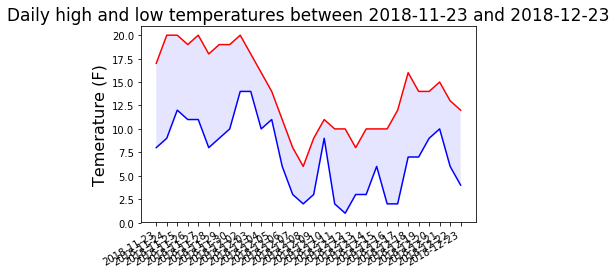

In [16]:
def Task2():
    '''Two Lines Plot: Daily high and low temperatures latest 30 day.'''
    col_1 = df['日期'].sort_values()
    dates = col_1.values[-30:]
    index = col_1.index
    col_2 = df['最高气温']
    highs = col_2.reindex(index).values[-30:]
    col_3 = df['最低气温']
    lows = col_3.reindex(index).values[-30:]

    fig, ax = plt.subplots()  # create a fig and a plot
    ax.plot(dates, highs, 'r', dates, lows, 'b')
    plt.fill_between(dates, highs, lows, facecolor='blue', alpha=0.1)

    plt.title("Daily high and low temperatures between {} and {}".format(dates[0], dates[-1]), fontsize=17)
    plt.ylabel("Temerature (F)", fontsize=16)
    fig.autofmt_xdate()

    fig.savefig("Temp.png")
    plt.show()
    
Task2()

### Task 3:  Two subplots

Draw two plots, one is the plot in Task 2 and the another is the line of difference in temperature in the latest 30 days.

<img src="figures/result.jpg">

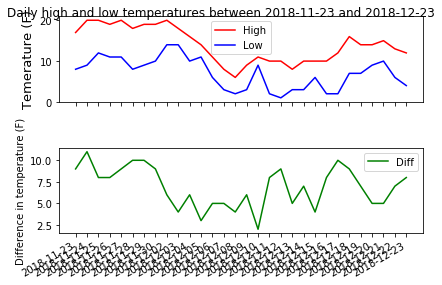

In [17]:
def Task3():
    '''Two plots'''
    col_1 = df['日期'].sort_values()
    dates = col_1.values[-30:]
    index = col_1.index
    col_2 = df['最高气温']
    highs = col_2.reindex(index).values[-30:]
    col_3 = df['最低气温']
    lows = col_3.reindex(index).values[-30:]

    diff = (df['最高气温'] - df['最低气温']).reindex(index).values[-30:]

    fig, axs = plt.subplots(2, 1)
    axs[0].plot(dates, highs, 'r', label="High")
    axs[0].plot(dates, lows, 'b', label="Low")

    axs[0].set_ylabel("Temerature (F)", fontsize=13)
    axs[0].legend()

    axs[1].plot(dates, diff, 'g', label="Diff")
    axs[1].set_ylabel('Difference in temperature (F)', fontsize=10)
    axs[1].legend()
    fig.autofmt_xdate()
    fig.tight_layout()
    fig.suptitle("Daily high and low temperatures between {} and {}".format(dates[0], dates[-1]), fontsize=12)
    plt.show()
#     plt.title("Daily high and low temperatures between {} and {}")
    
Task3()